# Boston's Red Sox vs Seattle's Mariners as told by Airbnb

This project was developed as part of the requirements for Udacity's Data Science Nanodegree Program. It takes a look at Airbnb Data of listings from Boston and Seattle between 2016 and 2017. The main questions addressed here are:

1.	What is the effect of time on listing price both in Seattle and in Boston? Is this effect different on each city?
2.	Is there any difference in the amenities offered in Boston vs. Seattle?
3.	Do amenities have an impact on the bookability of a listing and if so, how different is it on each city?

The data was provided by Airbnb and Kaggle and available [here](https://www.kaggle.com/airbnb/seattle/data)
and [here](https://www.kaggle.com/airbnb/boston). These datasets are comprised of the following files per city:
- *calendar.csv*: extract of listings per calendar day and their price
- *listings.csv*: extract of listings' attributes (location, host, reviews, etc.)

The remainder of this study is organized as follows: in [Data Understanding](#data_understanding) an overview of the information available in these datasets is provided. In [Data Preparation](#data_preparation) the corresponding data cleaning and data transformation steps are done. The [Modeling](#modeling) Section includes traning and testing predictive models, whereas the [Evaluation](#evaluation) Section presents findings and conclusions.

## Data Understanding <a name=data_understanding></a>

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from pathlib import Path
import sys
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

## Import internal modules
sys.path.append('..')
from src.config import config as cf
from src import data as dt

## matplotlib configurations
%matplotlib inline
plt.style.use('fivethirtyeight')

As a first step, we read the data from the *.csv* files

In [59]:
## Read calendar.csv data
b_calendar = pd.read_csv(cf.data_dir.joinpath('boston_calendar.csv'))
s_calendar = pd.read_csv(cf.data_dir.joinpath('seattle_calendar.csv'))

b_calendar['city'] = 'Boston'
s_calendar['city'] = 'Seattle'

calendar = b_calendar.append(s_calendar, sort = False)

In [60]:
## Read listings.csv data
b_listings = pd.read_csv(cf.data_dir.joinpath('boston_listings.csv'))
s_listings = pd.read_csv(cf.data_dir.joinpath('seattle_listings.csv'))

b_listings['city'] = 'Boston'
s_listings['city'] = 'Seattle'

listings = b_listings.append(s_listings, sort = False)

Secondly, general information on each dataset is displayed, mainly shape size, column types and an overview on missing values.

The dataframe has in total 2702460 rows and 5 features.

There are the following number of features per type:

object    4
int64     1
dtype: int64

20.0% of the features have missing values


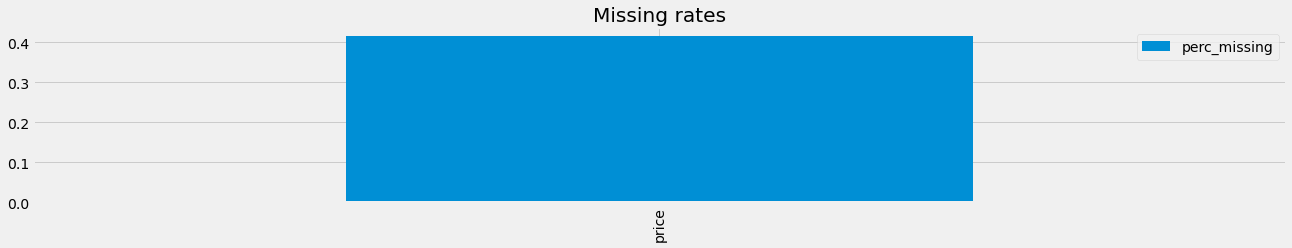

In [61]:
## First view at calendar data and plot columns with mire than 15% missing values

plt.rcParams['figure.figsize'] = (20,3)
dt.data_first_look(calendar, perc_missing=0.15)

In [62]:
print("-- Proportion of NAs\n")
print(calendar.isna().sum()/calendar.shape[0])

print("\n-- NAs per city on price column\n")
calendar.groupby(['city'])['price'].apply(lambda _df: _df.isna().sum())



-- Proportion of NAs

listing_id    0.000000
date          0.000000
available     0.000000
price         0.416243
city          0.000000
dtype: float64

-- NAs per city on price column



city
Boston     665853
Seattle    459028
Name: price, dtype: int64

The dataframe has in total 7403 rows and 95 features.

There are the following number of features per type:

object     65
float64    17
int64      13
dtype: int64

54.74% of the features have missing values


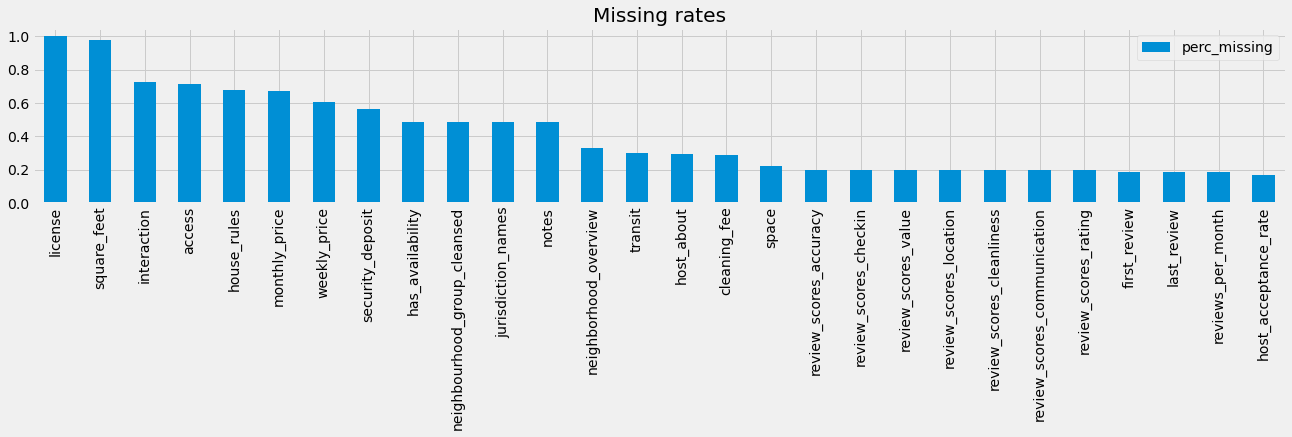

In [63]:
## First view at listings data and plot columns with mire than 15% missing values

plt.rcParams['figure.figsize'] = (20,3)
dt.data_first_look(listings, perc_missing = 0.15)

In [64]:
print("-- Proportion of NAs\n")
print(listings.isna().sum()/listings.shape[0])

print("\n-- NAs per city on price column\n")
listings.groupby(['city']).apply(lambda _df: _df.isna().sum())



-- Proportion of NAs

id                                  0.000000
listing_url                         0.000000
scrape_id                           0.000000
last_scraped                        0.000000
name                                0.000000
                                      ...   
cancellation_policy                 0.000000
require_guest_profile_picture       0.000000
require_guest_phone_verification    0.000000
calculated_host_listings_count      0.000000
reviews_per_month                   0.186816
Length: 95, dtype: float64

-- NAs per city on price column



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
city,,,,,,,,,,,,,,,,,,,,,
Boston,0,0,0,0,0,143,1057,0,0,1415,...,821,0,3585,3585,0,0,0,0,0,756
Seattle,0,0,0,0,0,177,569,0,0,1032,...,656,0,3818,0,0,0,0,0,0,627


As for the numeric features, the following provides general statistical information:

In [65]:
calendar.describe()

,listing_id
count,2.702460e+06
mean,6.950805e+06
std,4.052440e+06
min,3.335000e+03
25%,3.865313e+06
50%,7.035369e+06
75%,9.504211e+06
max,1.493346e+07


In [66]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,7.403000e+03,7.403000e+03,7.403000e+03,7401.000000,7401.000000,7403.000000,7403.000000,7403.000000,7373.000000,7387.000000,...,5943.000000,5922.000000,5932.000000,5925.000000,5934.000000,5926.000000,5926.000000,0.0,7403.000000,6020.000000
mean,6.950001e+06,2.016049e+13,2.021053e+07,32.222537,32.222537,45.067727,-97.515448,3.200189,1.241150,1.282659,...,93.316002,9.540865,9.417229,9.721181,9.733569,9.518056,9.319777,NaN,7.686073,2.028161
std,4.052397e+06,4.009296e+08,1.962309e+07,123.585161,123.585161,2.643568,25.613198,1.890166,0.549408,0.823251,...,8.207451,0.821783,0.999271,0.682247,0.656589,0.775312,0.892824,NaN,21.465871,1.968696
min,3.335000e+03,2.016010e+13,4.193000e+03,0.000000,0.000000,42.235942,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.010000
25%,3.864100e+06,2.016010e+13,4.343164e+06,1.000000,1.000000,42.345668,-122.330837,2.000000,1.000000,1.000000,...,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.590000
50%,7.035240e+06,2.016010e+13,1.448650e+07,1.000000,1.000000,47.542907,-122.276419,2.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,1.000000,1.370000
75%,9.500804e+06,2.016091e+13,3.028359e+07,4.000000,4.000000,47.624460,-71.079518,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,3.000000,2.890000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,47.733358,-71.000100,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,136.000000,19.150000


There are some issues regarding these dataset that need to be addressed so that our analyses can be performed. Mainly there are issues like missing values, outliers, and columns with wrong data type. These are addressed in the following Section.

## Data Preparation <a name=data_preparation></a>

For clarity puposes each of the datasets will be prepared separately, as the resulting cleaned datasets will be used to address different business questions.

### Calendar data

Almost half of all entries have missing prices being Boston the city with the most NAs. Even though removing entries with NAs would gratelly reduce the dataset, there is no way we could impute values in this column accuratelly and confidently. Therefore we remove entries with missing values.

In [56]:
calendar_cln = calendar.dropna(subset = ['price'], axis = 0)

We also observe some data type issues. First, we notice that the data type of the date column is wrong. Therefore we change it to date format. Second, we observe that the price is declared as an object type and that the values contain a "$" sign. Therefore some transformations are needed.

In [67]:
## Change date column format
todate = lambda val: pd.to_datetime(val)
calendar_cln.loc[:,'date'] = calendar_cln['date'].apply(todate)

## Change price column format
calendar_cln.loc[:,'price'] = calendar_cln.loc[:,'price'].str.replace('$', '')
calendar_cln.loc[:,'price'] = pd.to_numeric(calendar_cln.loc[:,'price'], errors = 'coerce')

In order to be able to analyse the listings initial price, we need to aggregate the prices with a mean price per day per city measure. As a result, an average listing price time series is obtained:

<ipython-input-68-6ba0bc6f26d6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_price = calendar_cln.groupby(['date','city'])['date','city','price'].mean().reset_index()


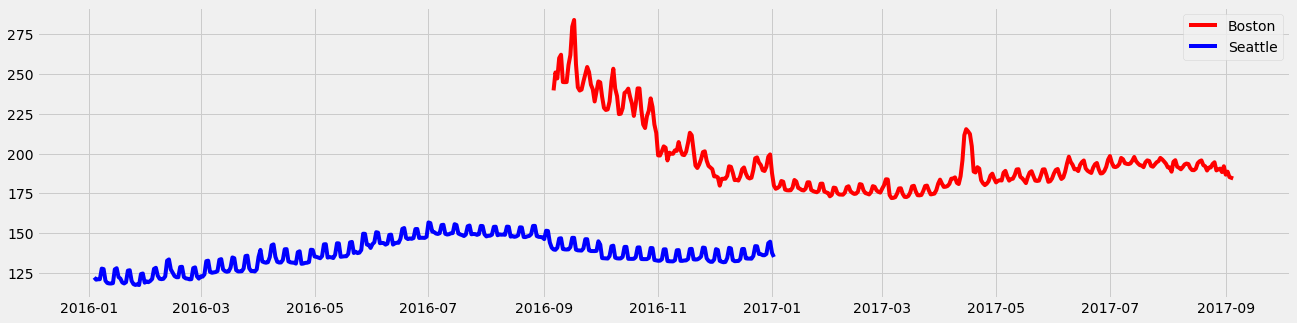

In [68]:
avg_price = calendar_cln.groupby(['date','city'])['date','city','price'].mean().reset_index()
plt.figure(figsize = [20, 5]);
plt.plot(avg_price.loc[avg_price['city'] == 'Boston']['date']
            , avg_price.loc[avg_price['city'] == 'Boston']['price']
            , color = "red"
            , label = 'Boston');
plt.plot(avg_price.loc[avg_price['city'] == 'Seattle']['date']
            , avg_price.loc[avg_price['city'] == 'Seattle']['price']
            , color = "blue"
            , label = 'Seattle');
plt.legend();
plt.show();

We observe that both time series begin in different points of time with at most 4 months overlap among them. Even though a simple direct inspection already provides us with the first insights, additional operations need to be made to be able to do a direct comparison. For this purpose we make use of a new colum containing the number of days since the first listing, i.e., observation days (respective to each city), and thus becoming a "normalized" time column.

Start of the observations in Boston:2016-09-06 00:00:00
Start of the observations in Seattle:2016-01-04 00:00:00


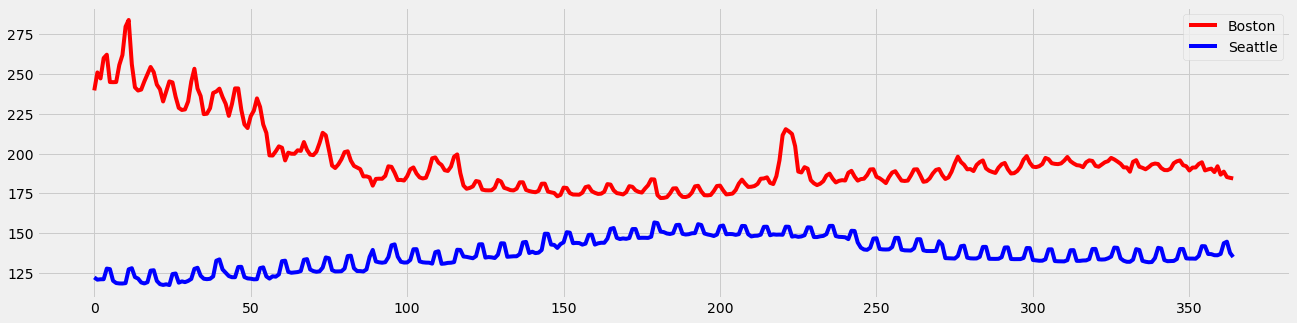

In [69]:
start_date_boston = avg_price.loc[avg_price['city'] == 'Boston', 'date'].min()
start_date_seattle = avg_price.loc[avg_price['city'] == 'Seattle', 'date'].min()

print('Start of the observations in Boston:{}'.format(start_date_boston))
print('Start of the observations in Seattle:{}'.format(start_date_seattle))

avg_price['norm_days'] = np.where(avg_price['city']=="Boston",
                                 avg_price['date'] - start_date_boston,
                                 avg_price['date'] - start_date_seattle
                                 )
avg_price['norm_days'] = avg_price['norm_days'].dt.days.astype('int16')
plt.figure(figsize = [20, 5]) 
plt.plot(avg_price.loc[avg_price['city'] == 'Boston']['norm_days']
            , avg_price.loc[avg_price['city'] == 'Boston']['price']
            , color = "red"
            , label = 'Boston')
plt.plot(avg_price.loc[avg_price['city'] == 'Seattle']['norm_days']
            , avg_price.loc[avg_price['city'] == 'Seattle']['price']
            , color = "blue"
            , label = 'Seattle')
plt.legend()
plt.show()

### 1. What is the effect of time on listing price both in Seattle and in Boston? Is this effect different on each city?

With the previously prepared data, we are able to address the first business question regarding time effects on listing price on both cities. For this we obtain the following plot:

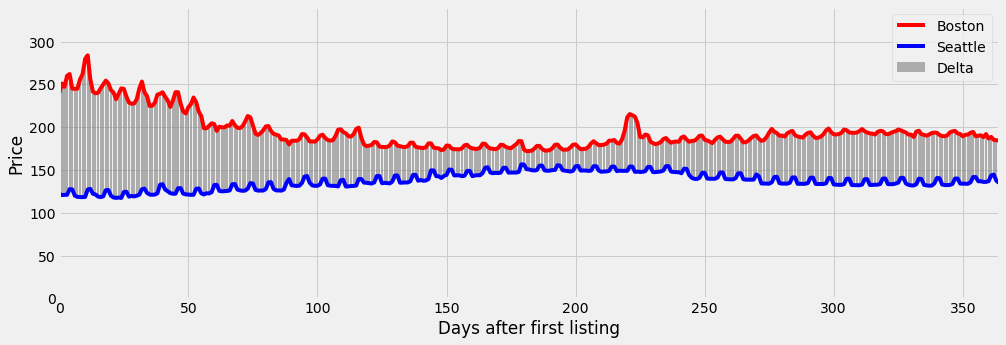

In [70]:
avg_price_w = avg_price.pivot(index = 'norm_days', columns = 'city', values = 'price').reset_index()
avg_price_w['delta'] = avg_price_w['Boston'] - avg_price_w['Seattle']
plt.figure(figsize = [15, 5]) 
plt.plot(avg_price_w['norm_days']
            , avg_price_w['Boston']
            , color = "red"
            , label = 'Boston')
plt.plot(avg_price_w['norm_days']
            , avg_price_w['Seattle']
            , color = "blue"
            , label = 'Seattle')
plt.bar(avg_price_w['norm_days']
        , height = avg_price_w['delta']
        ,  bottom = avg_price_w['Seattle']
        , color = "grey"
        , label = 'Delta'
        , alpha = 0.6)
plt.legend()
plt.xlim(0, avg_price['norm_days'].max())
plt.ylim(0, avg_price['price'].max() * 1.2)
plt.ylabel('Price')
plt.xlabel('Days after first listing')
plt.show()

Based on first visual interpretation of the data we can make the following observations:

The listing prices in Boston are higher than in Seattle throughout the observation period.
Overall the trends of these series have opposite behaviours, with, e.g., Seattle's prices peaking around after the first 180 observation days, whereas Boston's prices hit bottom at around the same time.
Boston's prices are more sensitive to time as it can be seen in the initial steep decline of the first 100 observation days.

### Listings data

For our research question we focus on *amenities*, *availability*, and *city*. At first glance, the selected columns don't have missing values. There is, however, a formatting issue regarding the *amenities* column: a single column can contain multiple amenities, as the values are in a string separated by commas. Therefore additional operations are needed.

In [71]:
listings_red = listings[["amenities", 'availability_30', "city"]].reset_index(drop = True)

print('There are {} entries with empty amenities'.format(np.sum(listings_red['amenities'] == '{}')))

listings_red = listings_red[listings_red['amenities'] != '{}']

dummies_amenities = pd.get_dummies(
    listings_red['amenities'].str.replace('}','').str.replace('{','').str.split(',').apply(pd.Series).stack()
).sum(level = 0).reset_index(drop = True)

dummies_amenities.head()

There are 77 entries with empty amenities


,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""","""First Aid Kit""","""Free Parking on Premises""",...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,0,0,0,0,0,0,1,1,0,1,...,0,0,1,0,0,1,0,1,1,1
1,0,1,0,0,1,0,1,1,0,0,...,0,1,1,1,1,1,0,1,1,1
2,0,1,0,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,1,1,1
3,0,1,0,0,1,0,0,1,1,1,...,1,1,1,1,1,1,0,1,1,1
4,0,1,0,0,1,0,0,0,1,0,...,0,1,1,1,1,1,0,1,0,0


The resulting encoded dataframe of amenities can be then joined to the original dataframe. At the same time, we drop the original amenities columns, since it is no longer needed. Lastly, the availability column could be interpreted as the reverse measure of bookability: the least avaiable a listing is, the more often is booked. Thus we can transform the average availability per day into a booking ration. 

In [72]:
df_dummies = pd.concat([listings_red, dummies_amenities], axis = 1).drop(['amenities'], axis = 1)
df_dummies['booking_ratio'] =  1 - df_dummies['availability_30']/30
df_dummies.drop(['availability_30'], axis = 1, inplace = True)

### 2. Is there any difference in the amenities offered in Boston vs. Seattle?
At this point we are able to address the second business question regarding the structure of amenities in the listings per city.

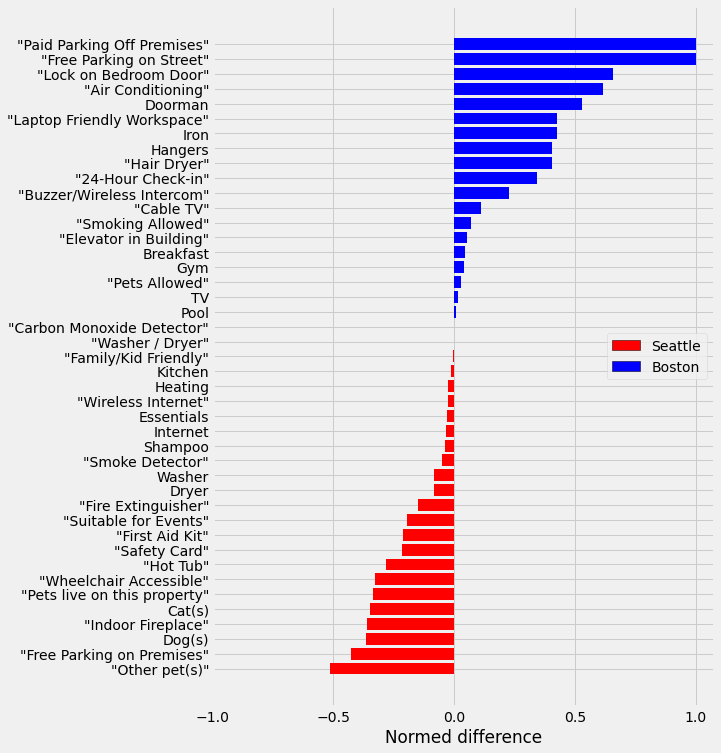

In [73]:
legend_elements = [Patch(facecolor='red', edgecolor='black',label='Seattle'),
                   Patch(facecolor='blue', edgecolor='black',label='Boston')
                  ]

agg_amenities = df_dummies.drop('booking_ratio', axis = 1).groupby('city').sum().reset_index(level = 0).melt(id_vars = 'city', var_name = 'amenity', value_name = 'count')
agg_amenities = agg_amenities.pivot(index = 'amenity', columns = 'city', values = 'count').reset_index()
agg_amenities = agg_amenities[~agg_amenities.amenity.str.contains("translation")]
agg_amenities['Delta'] = (agg_amenities.Boston - agg_amenities.Seattle) / (agg_amenities.Boston + agg_amenities.Seattle)
agg_amenities = agg_amenities.sort_values(by = 'Delta')

my_color = np.where(agg_amenities['Delta'] >=0, 'blue', 'red')
legend_elm = [Patch(facecolor='blue', label='Boston'), Patch(facecolor='red', label='Seattle')]

plt.rcParams['figure.figsize'] = (8,12)
plt.barh(agg_amenities['amenity'], agg_amenities['Delta'], color=my_color);
plt.xlabel('Normed difference');
plt.legend(handles = legend_elements, loc = 'center right');
plt.xticks(ticks = np.arange(-1,1.5, 0.5));

There is indeed a structural difference in the amenities per listing on each city, as very few amenities have < 10% difference. Some of the main insights obtained from this chart are as follow:
- Seattle’s host seem to favor pets since ‘Other pet(s)’, ‘Dog(s)’, ‘Cat(s)’, and ‘Pets live on this property’ are top amenities, whereas only ‘Pet(s) allowed’ is just marginally more dominant in Boston.
- Parking around Seattle’s listings is more convenient than in Boston (‘Free Parking on Premises’ in Seattle vs. ‘Free Parking on Streets’ or ‘Paid Parking on Premises’ in Boston.
- The differences suggest different lifestyles: whereas in Seattle some top amenities are ‘Indoor Fireplace’ or ‘Hot tub’, in Boston some are ‘Lock on bedroom door’, ‘Laptop frrendly Workspace’, and ‘24-Hour Check-in’ are more popular.

## Modeling <a name=modeling></a>

For this section wer aim to model the relation between amenities and the booking ratio for each city separatelly. Then we can compare the coefficients (*i.e.*, impact) on each citie's resulting model. By directly inspecting the histogram of the booking ratio we already observe Seattle and Boston have a diametrically different booking distribution. 

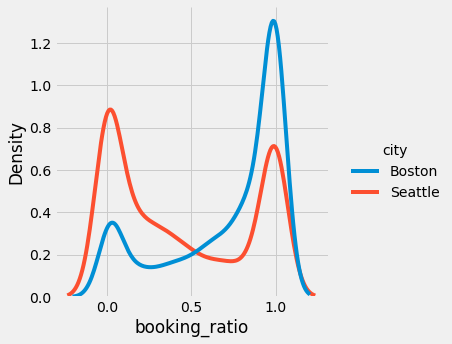

In [74]:
sns.displot(data = df_dummies, x = 'booking_ratio', hue = 'city', kind = 'kde');

In [80]:
## Fitting function
def reg_mod(df, response_col, test_size = 0.3, rand_state = 42):    
    ''' split dataframe into test and training sets, 
        train a random forest regressor, 
        test predictions in test set,
        calculate r2 score,
        and provide the feature importance
        INPUT:
        df: Pandas Dataframe
            test_size: float percentage of the dataframe to be reserved for testing
            rand_state: floeat seed for random numbers 
        OUTPUT: 
            r2 score for test set, 
            r2 score for training set,
            randomforest model,
            variable importance
    '''
    X = df.drop(response_col, axis=1)
    y = df[response_col]
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)

    #Predict using your model
    y_test_preds = rf.predict(X = X_test)
    y_train_preds = rf.predict(X = X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    var_imp = pd.DataFrame({'amenity': X_train.columns, 'feature_importance': rf.feature_importances_})


    return test_score, train_score, rf, var_imp #, X_train, X_test, y_train, y_test

In [81]:
## Regression model Boston
b_test_score, b_train_score, b_rf_model, b_var_imp = reg_mod(df_dummies.loc[df_dummies['city'] == 'Boston'].drop('city', 1).dropna(axis = 0)
                                                     , response_col = 'booking_ratio')
## Regression model Seattle
s_test_score, s_train_score, s_lm_model, s_var_imp = reg_mod(df_dummies.loc[df_dummies['city'] == 'Seattle'].drop('city', 1).dropna(axis = 0)
                                                     , response_col = 'booking_ratio')

In [82]:
print("Boston: for the linear model, the train score is {:.2f} and the test score is {:.2f}".format(b_test_score, b_train_score))
print("Seattle: for the linear model, the train score is {:.2f} and the test score is {:.2f}".format(s_test_score, s_train_score))

Boston: for the linear model, the train score is -0.07 and the test score is 0.76
Seattle: for the linear model, the train score is -0.15 and the test score is 0.78


In [83]:
b_var_imp = b_var_imp[~b_var_imp.amenity.str.contains("translation")]
s_var_imp = s_var_imp[~s_var_imp.amenity.str.contains("translation")]

### 3. Do amenities have an impact on the bookability of a listing and if so, how different is it on each city?

Using the information obtain from the prediction models, we address our last business question regarding on the relation of the amenities and success of a listing. 

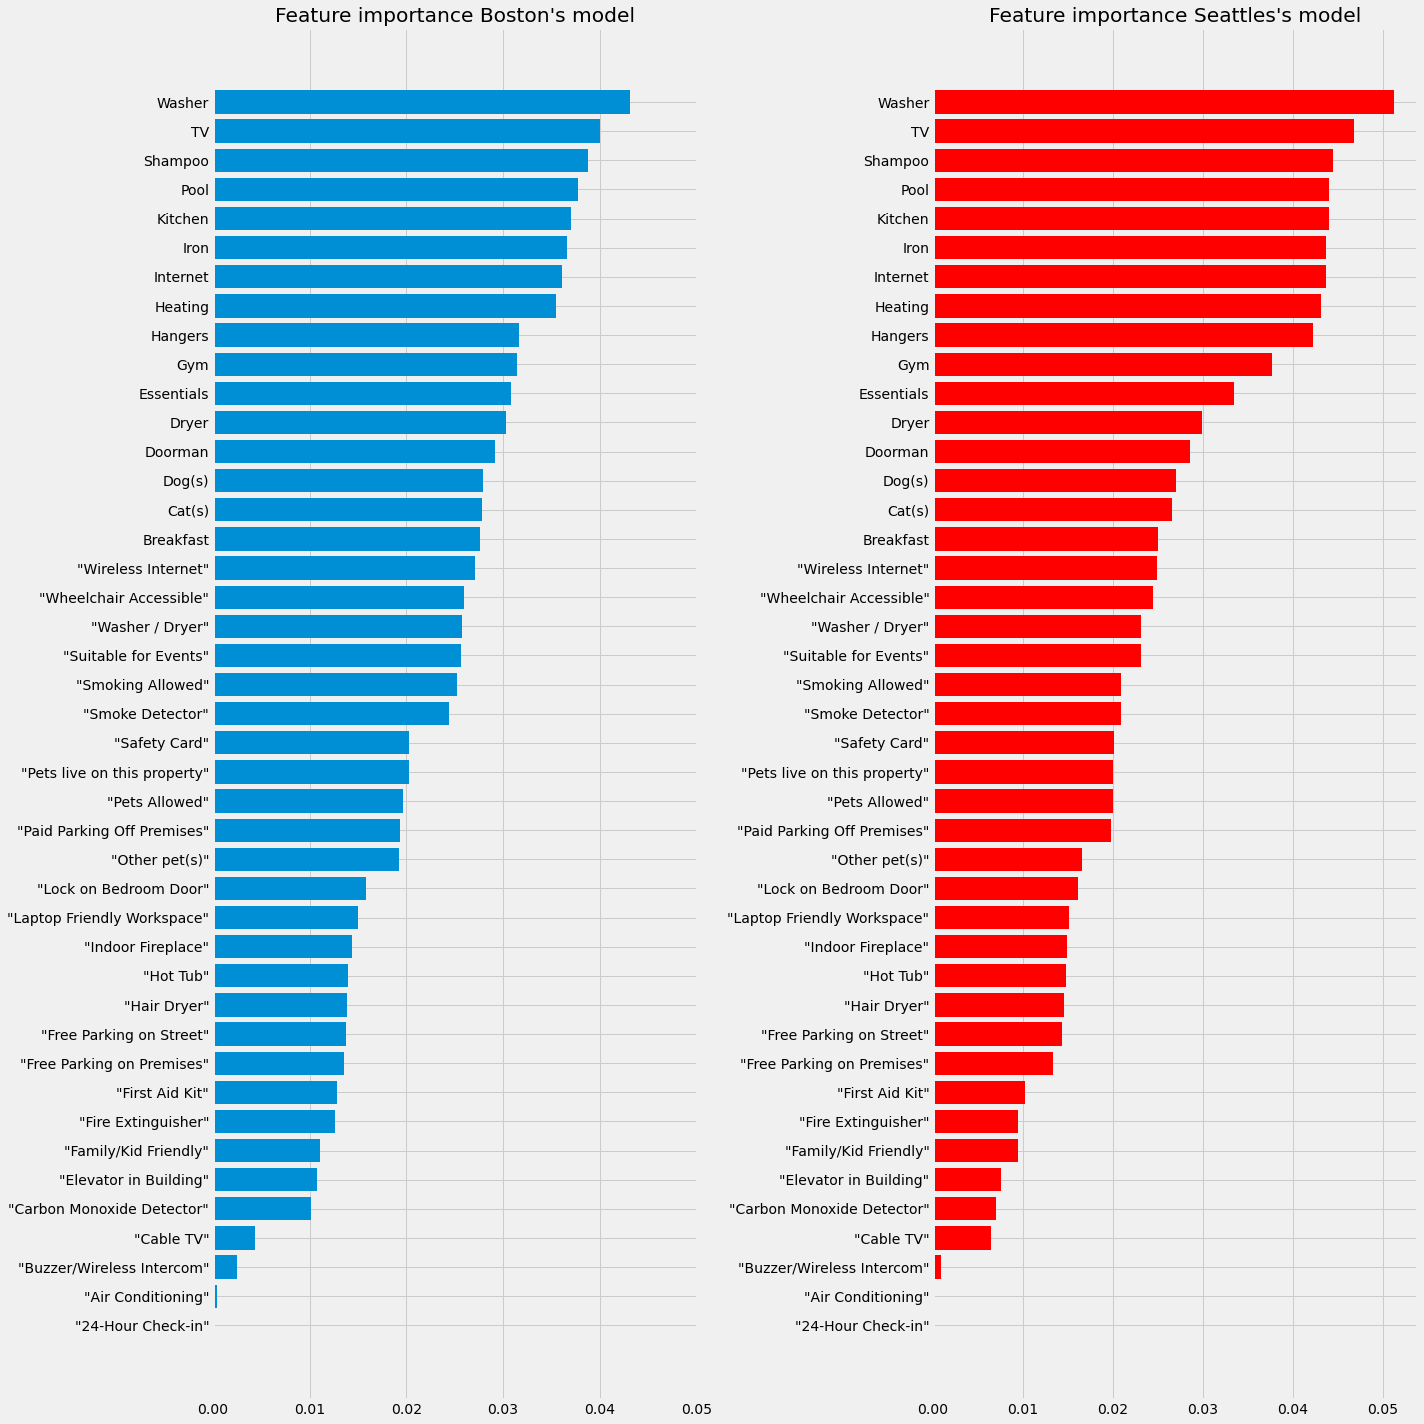

In [84]:
plt.rcParams['figure.figsize'] = (20,20)

plt.subplot(1,2,1)
plt.barh(b_var_imp.sort_values('feature_importance', ascending = False)['amenity'].sort_values(),
        b_var_imp.sort_values('feature_importance', ascending = False)['feature_importance'].sort_values())
plt.title("Feature importance Boston's model")
plt.xticks(np.arange(0,0.06, 0.01))
plt.subplot(1,2,2)
plt.barh(s_var_imp.sort_values('feature_importance', ascending = False)['amenity'].sort_values(),
        s_var_imp.sort_values('feature_importance', ascending = False)['feature_importance'].sort_values(),
        color = 'red')
plt.title("Feature importance Seattles's model")
plt.xticks(np.arange(0,0.06, 0.01))
plt.tight_layout();

The following observations can be made: 
- Even though amenities are structurally different between the two cities, their importance in a predictive model remains the same. This might not explain the differences in the distribution of the booking ratio, since surely more features need to be considered for this purpose, but certainly indicate this level of granularity on the amenities might not be suitable for modeling purposes. E.g. Some grouping of amenities might be needed.
- This analysis provides an importan insight for hosts listing properties on Airbnb: the amenities offered might be determined by local factors (e.g. weather, building regulations, etc.) but Airbnb’s business models showcase listings to a global audience. This means that local hosts, in order to improve the success of their listings, need to have a broader view on, e.g., which amenities to offer, which amenities to incorporate, etc.

## Evaluation <a name=evaluation></a>

For this post Airbnb data from listings in Boston and Seattle (2016 to 2017) was analyzed. There are three main insights obteined from this study:

1. Time has an impact on the listing prices. The magnitude of this impact, however, changes according the geographical location.
2. Amenities offered in listings in Boston or Seattle are different structurally although these differences could be caused by external factors.
3. The impact of specific amenities on the success of a listing showed the same behavior on both cities. Additional features are likely needed to predict success more accurately, but some insights for hosts wanting to improve their bookings can be already obtained